In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import emoji
import unicodedata

## Data reading

In [7]:
def merge_train_dev_test(path_train, path_dev, path_test):
    # Reading each file
    train= path_train
    en_train = pd.read_csv(train)
    en_train['source'] = 'train'
    dev= path_dev
    en_dev = pd.read_csv(dev)
    en_dev['source'] = 'dev'
    test= path_test
    en_test = pd.read_csv(test)
    en_test['source'] = 'test'
    # Concatenate the DataFrames
    en_merged = pd.concat([en_train, en_dev, en_test], ignore_index=True)
    return en_merged
    

## Data augmentation 

In [8]:
en_train= pd.read_csv('Dataset/English/en_train.csv')
en_aug= pd.read_csv('Dataset/English/train_augmented.csv')
en_aug = en_aug.drop(columns=['text']).rename(columns={'text_en': 'text'})
# Concatenate the original and translated datasets
df_combined = pd.concat([en_train, en_aug], ignore_index=True)
# Check the counts of 'multiclass' in the combined dataset
category_counts = df_combined['multiclass'].value_counts()
# Determine the minimum count of each class across both datasets
min_sub_counts = category_counts[['Generalized Hope', 'Unrealistic Hope', 'Realistic Hope','Sarcasm']].min()

# Sample from each category to balance the counts
df_balanced = pd.concat([
    df_combined[df_combined['multiclass'] == 'Generalized Hope'].sample(n=min_sub_counts, random_state=42),
    df_combined[df_combined['multiclass'] == 'Unrealistic Hope'].sample(n=min_sub_counts, random_state=42),
    df_combined[df_combined['multiclass'] == 'Realistic Hope'].sample(n=min_sub_counts, random_state=42),
    df_combined[df_combined['multiclass'] == 'Sarcasm'].sample(n=min_sub_counts, random_state=42),
    df_combined[df_combined['multiclass'] == 'Not Hope'].sample(n=4500, random_state=42)  
], ignore_index=True)
df_balanced['binary'].value_counts()
df_balanced.to_csv('Dataset/English/en_train_balanced.csv',index=False)


## Merging datasets without augmentation

In [9]:
en_merged= merge_train_dev_test('Dataset/English/en_train.csv','Dataset/English/en_dev.csv', 'Dataset/English/en_test_without_labels.csv')

In [10]:
es_merged= merge_train_dev_test('Dataset/Spanish/es_train.csv','Dataset/Spanish/es_dev.csv', 'Dataset/Spanish/es_test_without_labels.csv')

## Merging datasets with augmentation

In [11]:
en_merged_aug= merge_train_dev_test('Dataset/English/en_train_balanced.csv','Dataset/English/en_dev.csv', 'Dataset/Spanish/es_test_without_labels.csv')

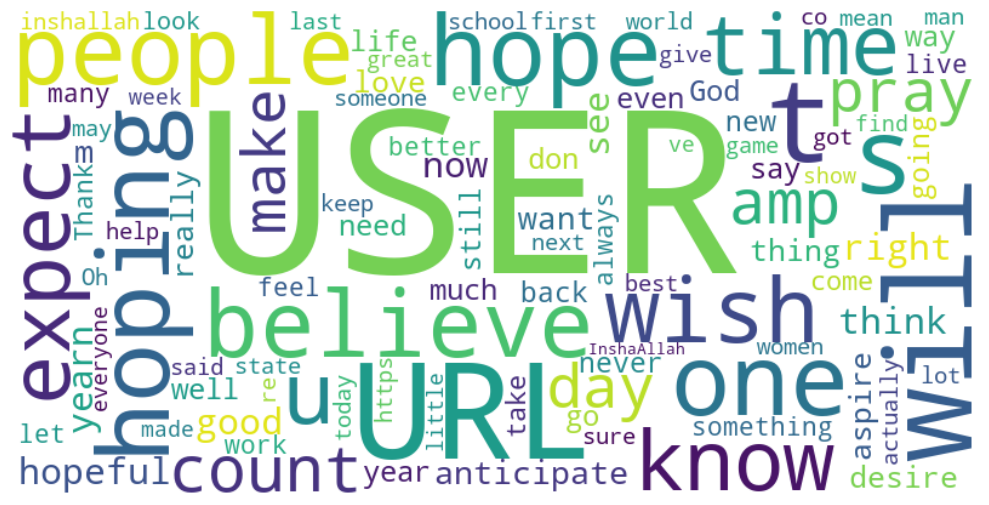

In [12]:
en_text = ' '.join(en_merged['text'].astype(str))
wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    max_words=100,
    collocations=False
).generate(en_text)

# Step 3: Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

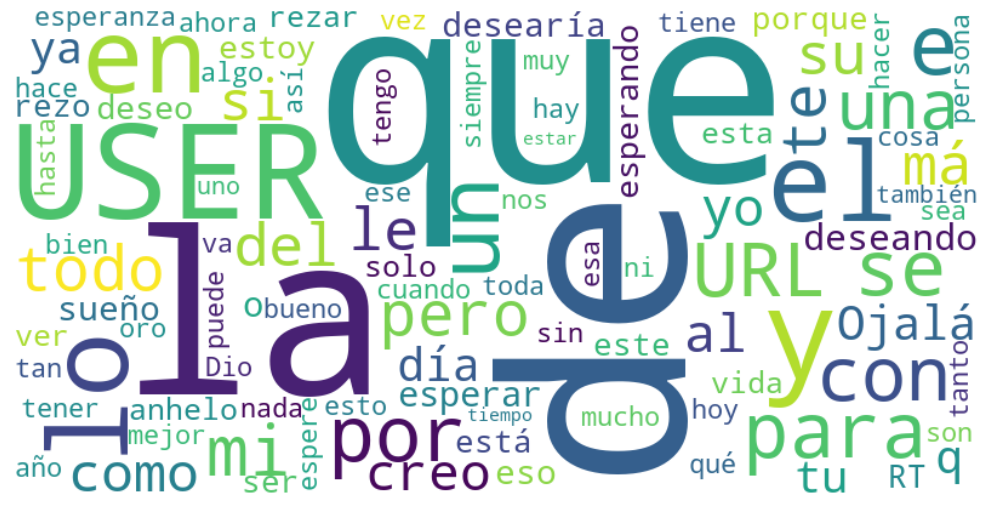

In [13]:
es_text = ' '.join(es_merged['text'].astype(str))
wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    max_words=100,
    collocations=False
).generate(es_text)

# Step 3: Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.show()

## Data cleaning

In [14]:
def remove_links(s):
    # remove url links
    return re.sub(r'\b(?:http|https):\/\/[\w.\/]*\b', "", s)

In [15]:
def remove_spaces(s):
    # remove spaces   
    return re.sub(r'\s+', ' ', s)

In [16]:
def remove_repeated_emojis(text):
    pattern = re.compile(r'([\U0001F300-\U0001F6FF\U0001F900-\U0001F9FF])\1+')
    return pattern.sub(r'\1', text)

In [17]:
# Convert emojis to their text descriptions
def replace_emoji_with_text(text):
    return emoji.demojize(text, delimiters=["[", "]"])

In [18]:
# remove punctuation
def nonAlphabetRemoval(word):
    if not isinstance(word, str):
        return ""

    # Define valid Spanish characters (lowercase and uppercase)
    spanish_chars = set("abcdefghijklmnñopqrstuvwxyz!?#0123456789 ")

    # Keep only characters in the Spanish alphabet (and spaces)
    return ''.join(char for char in word if char in spanish_chars)

In [19]:
def remove_corrupted_characters(text):
    return ''.join(c for c in text if not unicodedata.combining(c))

In [20]:
def data_cleaning(df):
    df['clean_text']= df['text'].str.lower()
    df['clean_text']= df['clean_text'].str.replace(r"á", "a", regex=True)
    df['clean_text']= df['clean_text'].str.replace(r"é", "e", regex=True)
    df['clean_text']= df['clean_text'].str.replace(r"í", "i", regex=True)
    df['clean_text']= df['clean_text'].str.replace(r"ó", "o", regex=True)
    df['clean_text']= df['clean_text'].str.replace(r"ú", "u", regex=True)
    df['clean_text']= df['clean_text'].str.replace(r"#user#", "", regex=True)
    df['clean_text']= df['clean_text'].str.replace(r"#url#", "", regex=True)
    df['clean_text']= df['clean_text'].str.replace(r"rt ", "", regex=True)
    df['clean_text']= df['clean_text'].apply(remove_links)
    df['clean_text']= df['clean_text'].apply(remove_spaces)
    df['clean_text']= df['clean_text'].apply(remove_repeated_emojis)
    df['clean_text']= df['clean_text'].apply(replace_emoji_with_text)
    df['clean_text']= df['clean_text'].apply(nonAlphabetRemoval)

In [21]:
data_cleaning(en_merged)
data_cleaning(en_merged_aug)
data_cleaning(es_merged)

In [22]:
en_merged['language']= 'english'
en_merged_aug['language']= 'english'
es_merged['language']= 'spanish'
dataset_merged = pd.concat([en_merged, es_merged], ignore_index=True)
dataset_merged_aug = pd.concat([en_merged_aug, es_merged], ignore_index=True)
dataset_merged.to_csv("dataset_merged_iberlef.csv", index=False,  encoding='utf-8-sig')
dataset_merged_aug.to_csv("dataset_merged_iberlef_augmented.csv", index=False,  encoding='utf-8-sig')